# Идеальное аниме для новичков

Аниме, как жанр аудиовизуального искусства, демонстрирует значительный рост популярности в последние десятилетия. Одним из ключевых аспектов анализа является оценка качества, которая, как правило, выражается в рейтингах и отзывах зрителей.

Целью данного исследования является проведение анализа оценок аниме с целью выявления статистических закономерностей и тенденций. В частности поставим перед собой следующие задачи:
 - **Сбор данных**: Используя инструменты веб-парсинга, реализуем скрипт для получения выборки, необходимой для дальнейшего анализа.
 - **Предварительный анализ**: Получим несмещенные, состоятельные и эффективные оценки для составления исчерпывающей выборки.
 - **Анализ оценок**: Построим *доверительные интервалы* и проверим *статистические гипотезы* на исчерпывающей выборке.
 - **Тенденции во времени**: Проанализируем изменения в оценках с течением времени.
 - **Исследование категорий**: Определим, какие жанры и студии наиболее популярны и получают самые большие средние оценки.

Итогом анализа станут рекомендации, основанные на статистике, для тех, кто ищет аниме, которое почти наверняка придется ему по душе. Это могут быть как люди, которые хотят начать, но не знает с чего, так и люди, которые ищут произведения, которые могут им понравиться.

### Импортируем необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.stats as st

from requests import get
from bs4 import BeautifulSoup
import re

import warnings

warnings.filterwarnings('ignore')

## Модуль 1: Сбор данных

В качестве сайта для сбора будем использовать [Animego.org](https://animego.org/), так как это один из самых популярных тематических сайтов в России, содержащий в себе всю необходимую информацию по каждому произведению. Также в нем уже реализован адрес для получения случайного аниме, что упростит составление репрезентативной выборки.

Проверим возможен ли парсинг сайта со стандартными агентами.

In [2]:
link = 'https://animego.org/anime/random'
response = get(link)

response

<Response [200]>

Ошибок нет, поэтому составим парсер. Информацию будем записывать в `pandas.DataFrame` для удобного взаимодействия с данными.

In [3]:
def parse_site(n: int) -> pd.DataFrame:
    df = pd.DataFrame([])
    while df.shape[0] != n:
        link = 'https://animego.org/anime/random'
        response = get(link)
        
        soup = BeautifulSoup(response.content, 'html.parser')
    
        item = {}
        
        try: item['title'] = soup.find('div', {'class': 'anime-title'}).h1.text 
        except Exception: continue

        if pd.isnull(item['title']): continue
            
        item['genres'] = ';'.join([a.text for a in soup.find_all('a', href=True) if 'genre' in a['href']])
        
        try:
            item['rating'] = float(soup.find('span', {'class': 'rating-value'}).text.replace(',', '.'))
            c = int(soup.find('div', {'class': 'rating-count'}).text)
            if c >= 30:
                item['rating_voters'] = c
            else:
                continue
        except Exception:
            continue
            
        try: item['season'] = [a.text for a in soup.find_all('a', href=True) if 'season' in a['href']][0]
        except Exception: item['season'] = None   
            
        try: item['studio'] = [a.text for a in soup.find_all('a', href=True) if 'studio' in a['href']][0] 
        except Exception: item['studio'] = None 
            
        try: item['origin'] = soup.find('dd', {'class': 'col-6 col-sm-8 mb-1'}).text 
        except Exception: item['origin'] = None
            
        try: item['pg'] = soup.find('dd', {'class': 'col-6 col-sm-8 mb-1 mt-1'}).text.strip() 
        except Exception: item['pg'] = None
            
        try: item['type'] = soup.find('dd', {'class': 'col-6 col-sm-8 mb-1'}).text 
        except Exception: item['type'] = None
            
        try: item['episode_count'] = int(soup.find_all('dd', {'class': 'col-6 col-sm-8 mb-1'})[1].text) 
        except Exception: item['episode_count'] = 1  
        if df.empty:
            df = pd.DataFrame([item])
        else:
            df = pd.concat([df, pd.DataFrame([item])], axis=0)
        df = df.drop_duplicates()
    df = df.set_index(np.arange(df.shape[0]))
    return df

In [4]:
parse_site(5)

,title,genres,rating,rating_voters,season,studio,origin,pg,type,episode_count
0,Ван-Пис: Приключение в глуби океана,Комедия;Приключения;Сёнэн;Супер сила;Фэнтези;Э...,7.8,534,None,Toei Animation,Спешл,16+,Спешл,1
1,Девушки и танки: Битва за Арису!,Военное;Школа,8.0,467,None,Actas,Спешл,16+,Спешл,3
2,Неправильный способ использования исцеляющей м...,Фэнтези;Экшен,8.6,12451,Зима 2024,Shin-Ei Animation,ТВ Сериал,16+,ТВ Сериал,13
3,Арифурэта: Сильнейший ремесленник в мире 2,Гарем;Приключения;Фэнтези;Экшен,7.8,13072,Зима 2022,asread,ТВ Сериал,16+,ТВ Сериал,12
4,"Сильнейший герой, обученный в тайном подземелье",Гарем;Приключения;Фэнтези;Экшен;Этти,7.7,11202,Зима 2021,None,ТВ Сериал,16+,ТВ Сериал,12


## Модуль 2: Предварительный анализ 

Отлично, парсер готов. Далее для составления выборки стоит ответственно подойти к количеству наблюдений. Чтобы определить необходимый объем выборки для достижения требуемой надежности доверительного интервала используется формула

![формула количества наблюдений](DATA/req_data.png)

Эту формулу и возьмем за основу для нахождения необходимого числа наблюдений, однако в числителе присутствует генеральная дисперсия, которую откуда-то нужно достать. Единственный возможный способ - получить оценку. Чем больше значений, тем точнее оценка дисперсии, так как она асимптотически стремится к истинному значению. Обычно асимптотика работает корректно при объеме выборки более 100, поэтому составим выборку из 125 значений и примем ее несмещенную оценку за дисперсию генеральной совокупности.

In [5]:
df = parse_site(125)
print(f'Выборка сожержит {df.title.nunique()} уникальных значений')
df.head(5)

Выборка сожержит 125 уникальных значений


,title,genres,rating,rating_voters,season,studio,origin,pg,type,episode_count
0,Девушка из оперы!!,Драма;Сёдзё;Школа,8.3,857,Лето 2021,Pine Jam,ТВ Сериал,18+,ТВ Сериал,13
1,Музыкальная школа звёзд 2,Музыка;Повседневность;Школа,5.7,106,Весна 2017,C-Station,ТВ Сериал,16+,ТВ Сериал,12
2,Усопшие,Вампиры;Детектив;Психологическое;Сверхъестеств...,8.6,2252,Лето 2010,Daume,ТВ Сериал,18+,ТВ Сериал,22
3,Дети на орбите,Космос;Фантастика,8.0,624,None,None,ONA,12+,ONA,6
4,Радуга: Семеро из шестой камеры,Драма;Исторический;Сэйнэн;Триллер,9.0,2004,Весна 2010,Madhouse Studios,ТВ Сериал,18+,ТВ Сериал,26


Теперь по ней определим несмещенную оценку дисперсии.

In [54]:
s = df.rating.std(ddof=1)
s ** 2

1.2021216884508092

Подставим это значение в формулу выше и получим необходимую для дальнейшего анализа численность выборки.

In [7]:
n = (1.96 ** 2 * s ** 2) / 0.05 ** 2 # будем строить 95%-ДИ с отклонением 0.05 
n = int(np.ceil(n))
n

1684

И наконец составим исчерпывающую выборку с помощью парсера.

In [8]:
df = parse_site(n)
print(f'Выборка сожержит {df.title.nunique()} уникальных значений')
df.head()

Выборка сожержит 1612 уникальных значений


,title,genres,rating,rating_voters,season,studio,origin,pg,type,episode_count
0,Мои девушки 2,Гарем;Комедия;Романтика;Сёнэн;Школа,7.6,1688,Осень 2023,SynergySP,ТВ Сериал,16+,ТВ Сериал,12
1,Волейбольный клуб старшей школы Сэйин,Драма;Повседневность;Спорт;Школа,7.5,1458,Зима 2021,David Production,ТВ Сериал,12+,ТВ Сериал,12
2,Компания «Маги-Люмьер»,Комедия;Сёнэн;Фэнтези;Экшен,7.5,133,Осень 2024,J.C. Staff,ТВ Сериал,16+,ТВ Сериал,1
3,Звучи! Эуфониум 2: Спешлы,Комедия;Музыка;Школа,7.2,137,None,None,Спешл,16+,Спешл,7
4,Граница пустоты 5: Спираль парадокса,Детектив;Драма;Романтика;Сверхъестественное;Тр...,8.8,603,None,ufotable,Фильм,18+,Фильм,1


Построим по этой выборке оценки параметров.

In [37]:
print(f'Оценка среднего рейтинга генеральной совокупности: {df.rating.mean()}')
print(f'Оценка стандартного отклонения рейтинга генеральной совокупности: {df.rating.std(ddof=1)}')

Оценка среднего рейтинга генеральной совокупности: 7.864192399049881
Оценка стандартного отклонения рейтинга генеральной совокупности: 1.0964131011853193


На будущее сохраним результат работы парсера в **csv-файл**

In [10]:
df.to_csv('anime_data.csv')

## Модуль 3: Анализ оценок

Построим **Доверительный инетрвал для среднего** генеральной совокупности и визуализируем распределение оценок.

In [61]:
se = df.rating.std(ddof=1) / np.sqrt(df.shape[0])
lam = 2.58 * se
sample_mean = df.rating.mean()

print(f'Истинное значение среднего генеральной совокупности лежит на отрезке: [{np.round(sample_mean - lam, 5)}; {np.round(sample_mean + lam, 5)}]')

Истинное значение среднего генеральной совокупности лежит на отрезке: [7.79526; 7.93312]


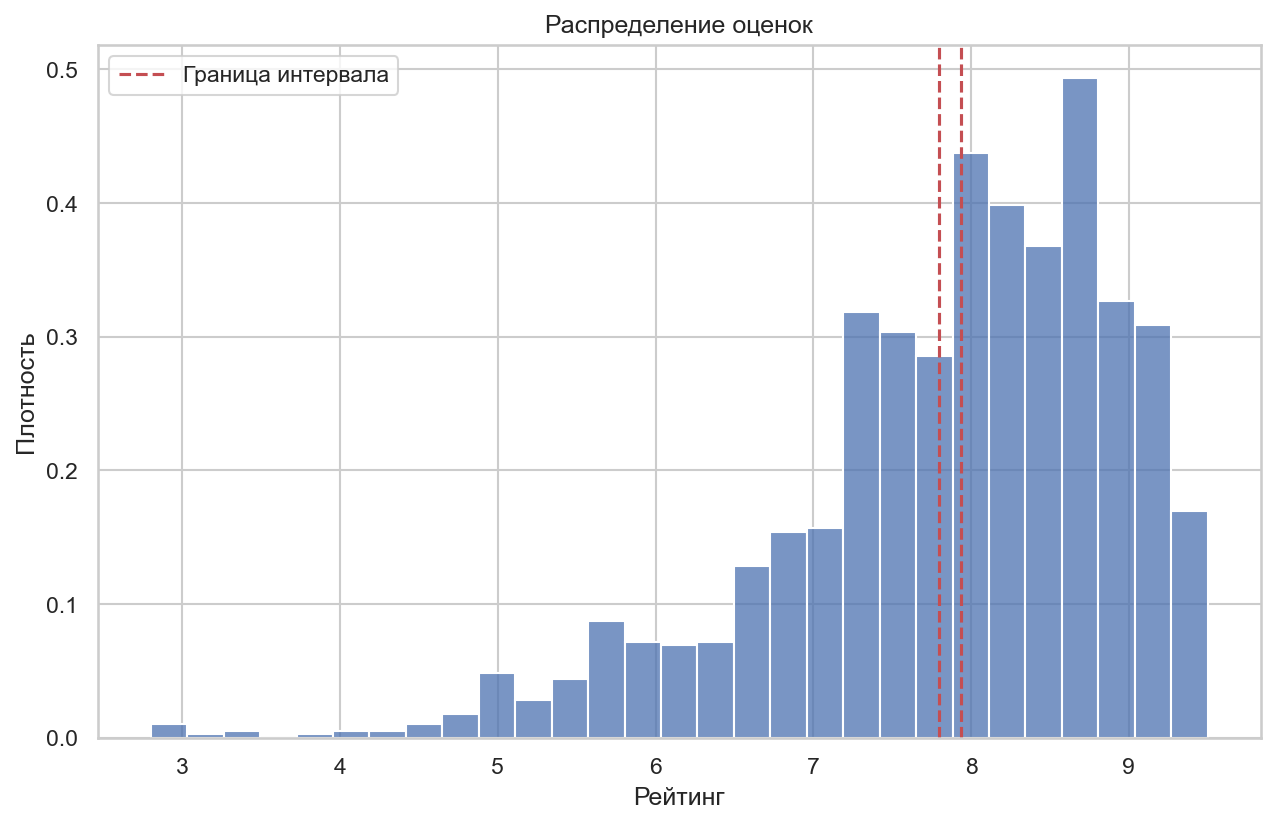

In [12]:
plt.figure(figsize=(10, 6), dpi=150)
sns.set(style="whitegrid")

sns.histplot(df.rating, fill=True, stat='density', palette='pastel')
plt.axvline(x=sample_mean - lam, ls='--', c='r', label='Граница интервала')
plt.axvline(x=sample_mean + lam, ls='--', c='r')
plt.title('Распределение оценок')
plt.xlabel('Рейтинг')
plt.ylabel('Плотность')
plt.legend(loc='upper left');

Также построим **Доверительный интервал для дисперсии** генеральной совокупности.

In [62]:
s = df.rating.std(ddof=1)
alpha = 0.05

left_border = ((n - 1) * s ** 2) / (stats.chi2(df=n-1).ppf(1 - alpha / 2))
right_border = ((n - 1) * s ** 2) / (stats.chi2(df=n-1).ppf(alpha / 2))

print(f'Истинное значение среднего генеральной совокупности лежит на отрезке: [{np.round(left_border, 5)}; {np.round(right_border, 5)}]')

Истинное значение среднего генеральной совокупности лежит на отрезке: [1.16148; 1.24495]


Сразу в глаза бросается то, что значения существенно смещены от предполагаемого центра оценивания. Убедимся в этом, проведя **статистический тест**, при помощи одновыборочного критерия Уилкоксона.
Сформулируем гипотезы:

- *H0: μ = 5*
- *H1: μ ≠ 5*

In [14]:
diff = df.rating - 5
diff = diff.dropna()
print(f'p_value = {stats.wilcoxon(diff)[1].round(5)}')

p_value = 0.0


Найдено существенное различие, **нулевая гипотеза о равенстве среднего пяти отвергается**.

Из этого можно сделать вывод, что люди склонны завышать оценки произведений, беря за среднее значение оценку 7.8, но никак не 5.

## Модуль 4: Тенденции во времени

Теперь проверим, улучшилось ли в среднем качество аниме с течением времени. Для этого отсортируем Датафрейм по сезону выпуска и построим **линию тренда** в оценках.

In [15]:
def extract_season_date(df):
    seasons = {'Зима': 1, 'Весна': 2, 'Лето': 3, 'Осень': 4}
    month, year = df.season.split()
    month = seasons[month]
    year = int(year)
    df.season = pd.to_datetime(f'{year}-{month}', format="%Y-%m")
    return df

In [16]:
season_df = df[['season', 'rating']]
season_df.dropna(inplace=True)
season_df = season_df.apply(extract_season_date, axis=1)
season_df.sort_values(by='season', inplace=True)
season_df = season_df.groupby('season').agg('mean')
season_df = season_df.reset_index().drop(columns=['season'])

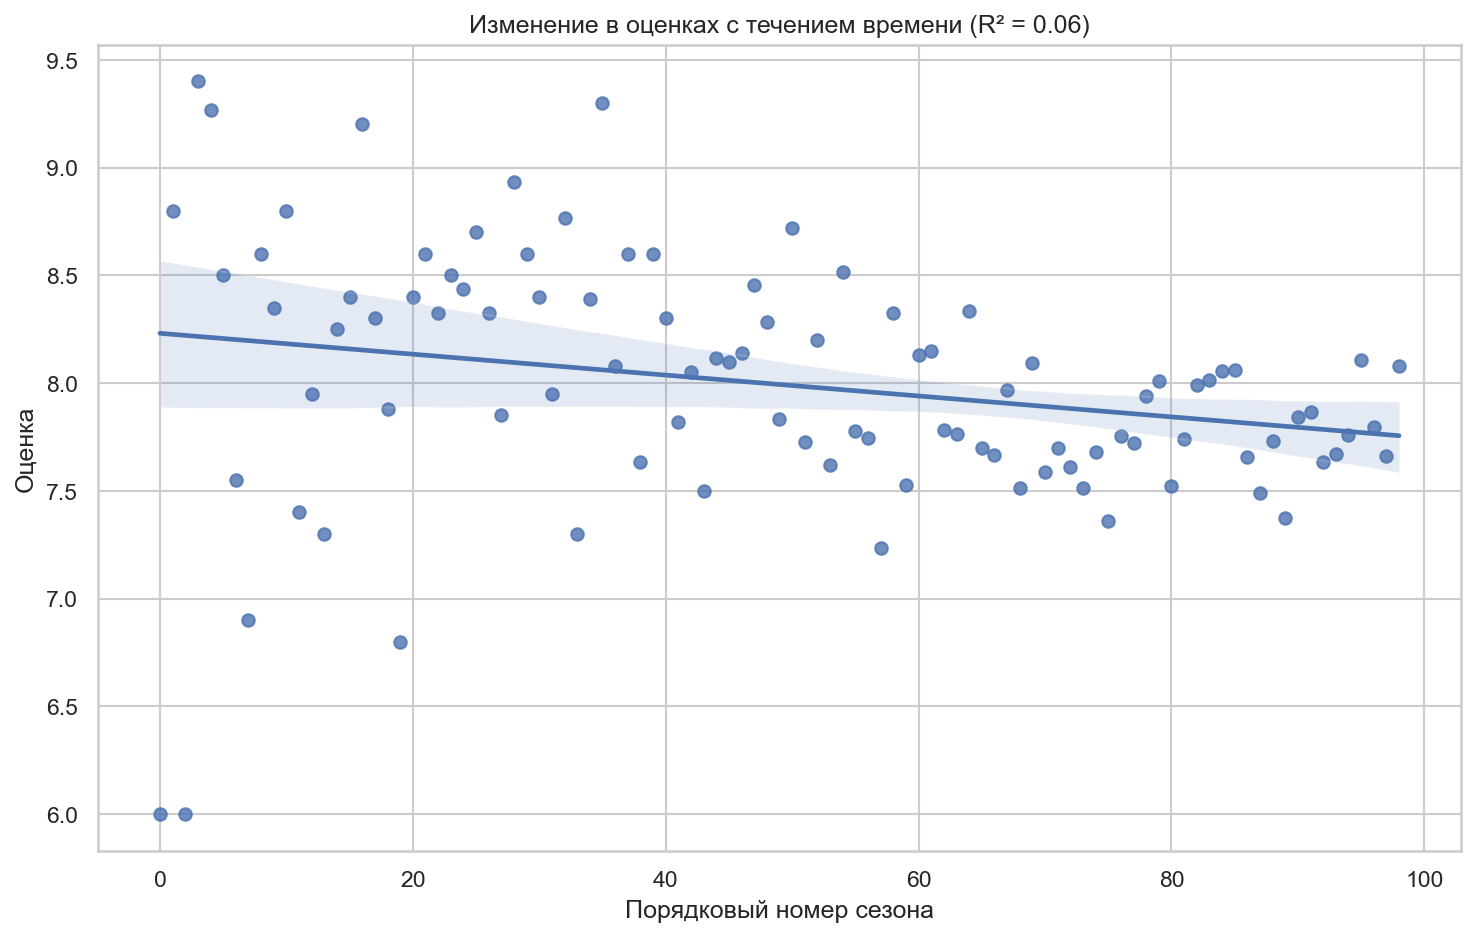

In [17]:
plt.figure(figsize=(10, 6), dpi=150)
sns.set(style="whitegrid")

r_square = np.corrcoef(season_df.rating.to_numpy(), season_df.index.to_numpy())[0][1] ** 2

sns.regplot(x=np.arange(season_df.shape[0]), y='rating', data=season_df)
plt.tight_layout()
plt.title(f'Изменение в оценках с течением времени (R² = {(r_square).round(2)})')
plt.ylabel('Оценка')
plt.xlabel('Порядковый номер сезона');

В среднем с течением времени **оценки аниме не улучшились**. Отмечу, что старых аниме довольно мало, из-за чего вариативность старых аниме внутри сезонных групп на порядок ниже.

## Модуль 5: Исследование категорий

Так как мы хотим найти произведения, которое окажется по душе каждому, необходимо исследовать категории. Анализ будем проводить по:
- Студиям - каждая студия имеет свой подход к рисовке, повествованию и вниманию к деталям.
- Жанрам - как и во всех видах повествования есть нишевые жанры, которые не всем понравятся.
- Типам произведения - фильмы, сериалы и остальные типы имеют разные бюджеты и подходы реализации.

Проверим влияние каждой из категорий на оценки, и если таковое найдется, то учтем это при рекомендации.

### Начнем со студий. Сгруппируем оценки по студиям, построим графики и проверим несколько гипотез.

Сформулируем гипотезу о том, что оценки не зависят от студии. То есть:

H0: μ₁ = ... = μₙ

H1: μ₁ ≠ ... ≠ μₙ (хотя бы 1)

In [80]:
studio_df = df[['studio', 'rating']]
studio_df = studio_df.dropna().groupby('studio').agg('mean')
studio_df.sort_values(by='rating', inplace=True, ascending=False)
studio_df.head()

,rating
studio,
Studio Ghibli,9.400000
Studio Bind,9.242857
IMAGIN,9.200000
Hoods Entertainment,9.000000
Egg Firm,9.000000


Посмотрим на средние оценки в самой низко оцененной и самой высоко оцененной студии.

In [81]:
print(f'Самая высоко оцененная студия: {studio_df.iloc[0].name}, рейтинг: {studio_df.iloc[0].rating}')
print(f'Самая низко оцененная студия: {studio_df.iloc[-1].name}, рейтинг: {studio_df.iloc[-1].rating}')

Самая высоко оцененная студия: Studio Ghibli, рейтинг: 9.4
Самая низко оцененная студия: Marvy Jack, рейтинг: 3.9


Пока результат говорит о том, что итоговая средняя оценка очень сильно зависит от студии. Чтобы не строить догадок проверим результат при помощи **Дисперсионного анализа (ANOVA-тест)**

In [20]:
model = ols('rating ~ C(studio)', data=df).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(studio),606.799533,172.0,4.218413,2.355117e-51
Residual,1142.400558,1366.0,NaN,NaN


Как мы и предполагали, **качество произведения зависит от студии создателя**.

Составим топ-30 аниме студий.

In [21]:
studio_df = df[['studio', 'rating']]
studio_df.head()

groupes_studio_df = studio_df.dropna().groupby('studio').agg('mean')
groupes_studio_df.sort_values(by='rating', inplace=True, ascending=False)
groupes_studio_df = groupes_studio_df.head(30).index

studio_mask = studio_df['studio'].isin(groupes_studio_df.to_list())

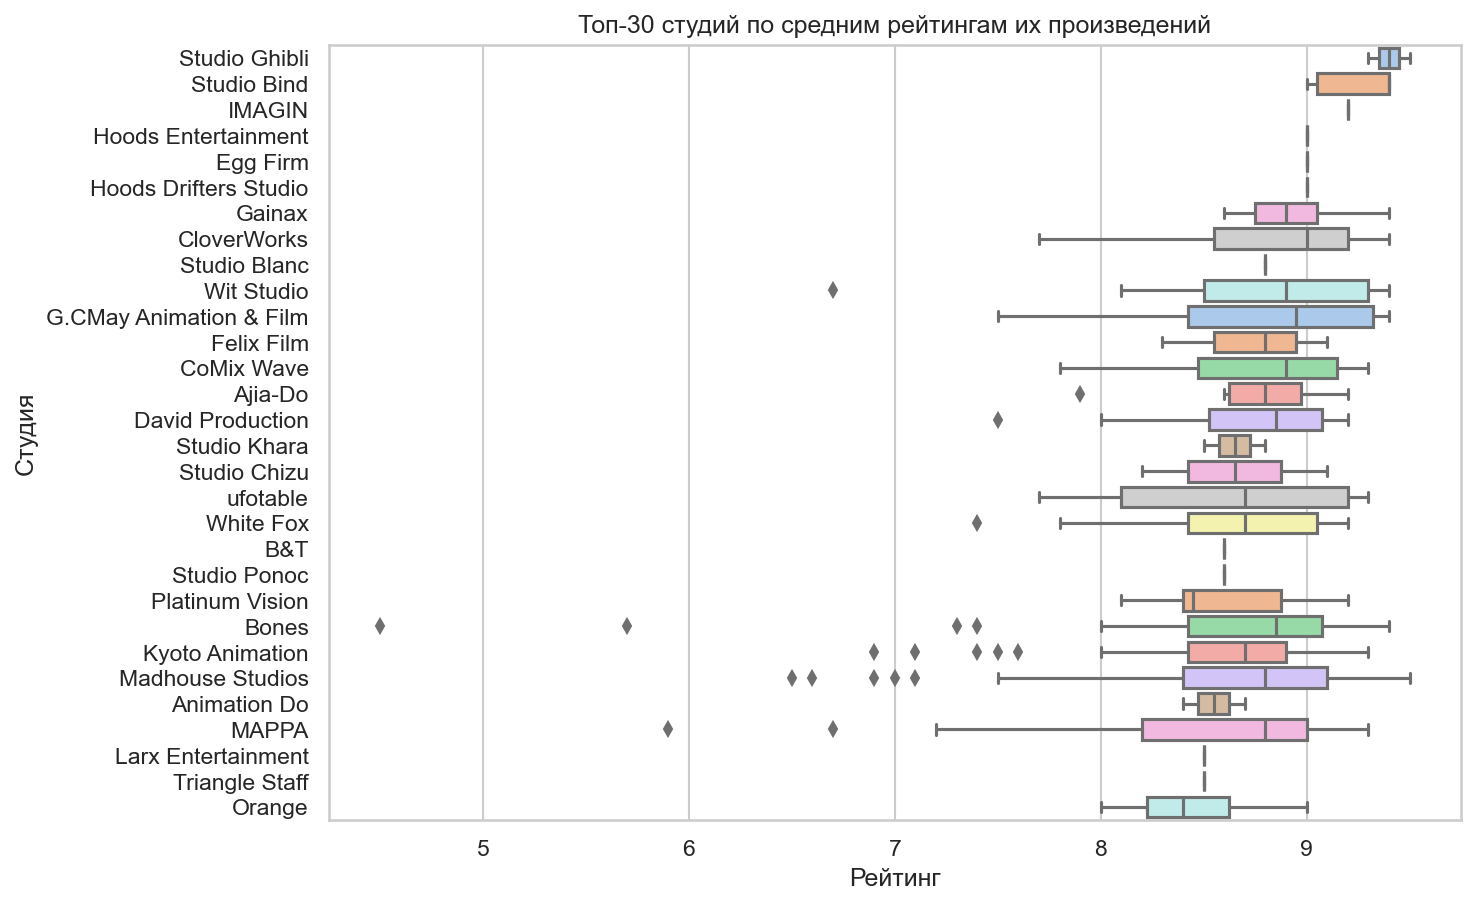

In [22]:
plt.figure(figsize=(10, 6), dpi=150)
sns.set(style="whitegrid")

sns.boxplot(x=studio_df[studio_mask]['rating'],
            y=studio_df[studio_mask]['studio'],
            order=groupes_studio_df,
           palette='pastel')

plt.tight_layout()
plt.xlabel('Рейтинг')
plt.ylabel('Студия')
plt.title('Топ-30 студий по средним рейтингам их произведений');

Треть групп, попавших в топ-30, имеют в себе 1 значение, что не очень информативно. Будем включать в топ-30 студии, у которых в выборку попали хотя бы пара наблюдений, дабы была хоть какая-то вариативность. Также для рекомендаций сохраним этот топ в переменную.

In [45]:
studio_df = df[['studio', 'rating']]
studio_df.head()

enough_count = studio_df.dropna().groupby('studio').agg('count')
enough_count = enough_count[enough_count['rating'] >= 2].index.to_list()

studio_df = studio_df[studio_df['studio'].isin(enough_count)]

groupes_studio_df = studio_df.dropna().groupby('studio').agg('median')
groupes_studio_df.sort_values(by='rating', inplace=True, ascending=False)
groupes_studio_df = groupes_studio_df.head(30).index
top_studios = groupes_studio_df

studio_mask = (studio_df['studio'].isin(groupes_studio_df.to_list()))

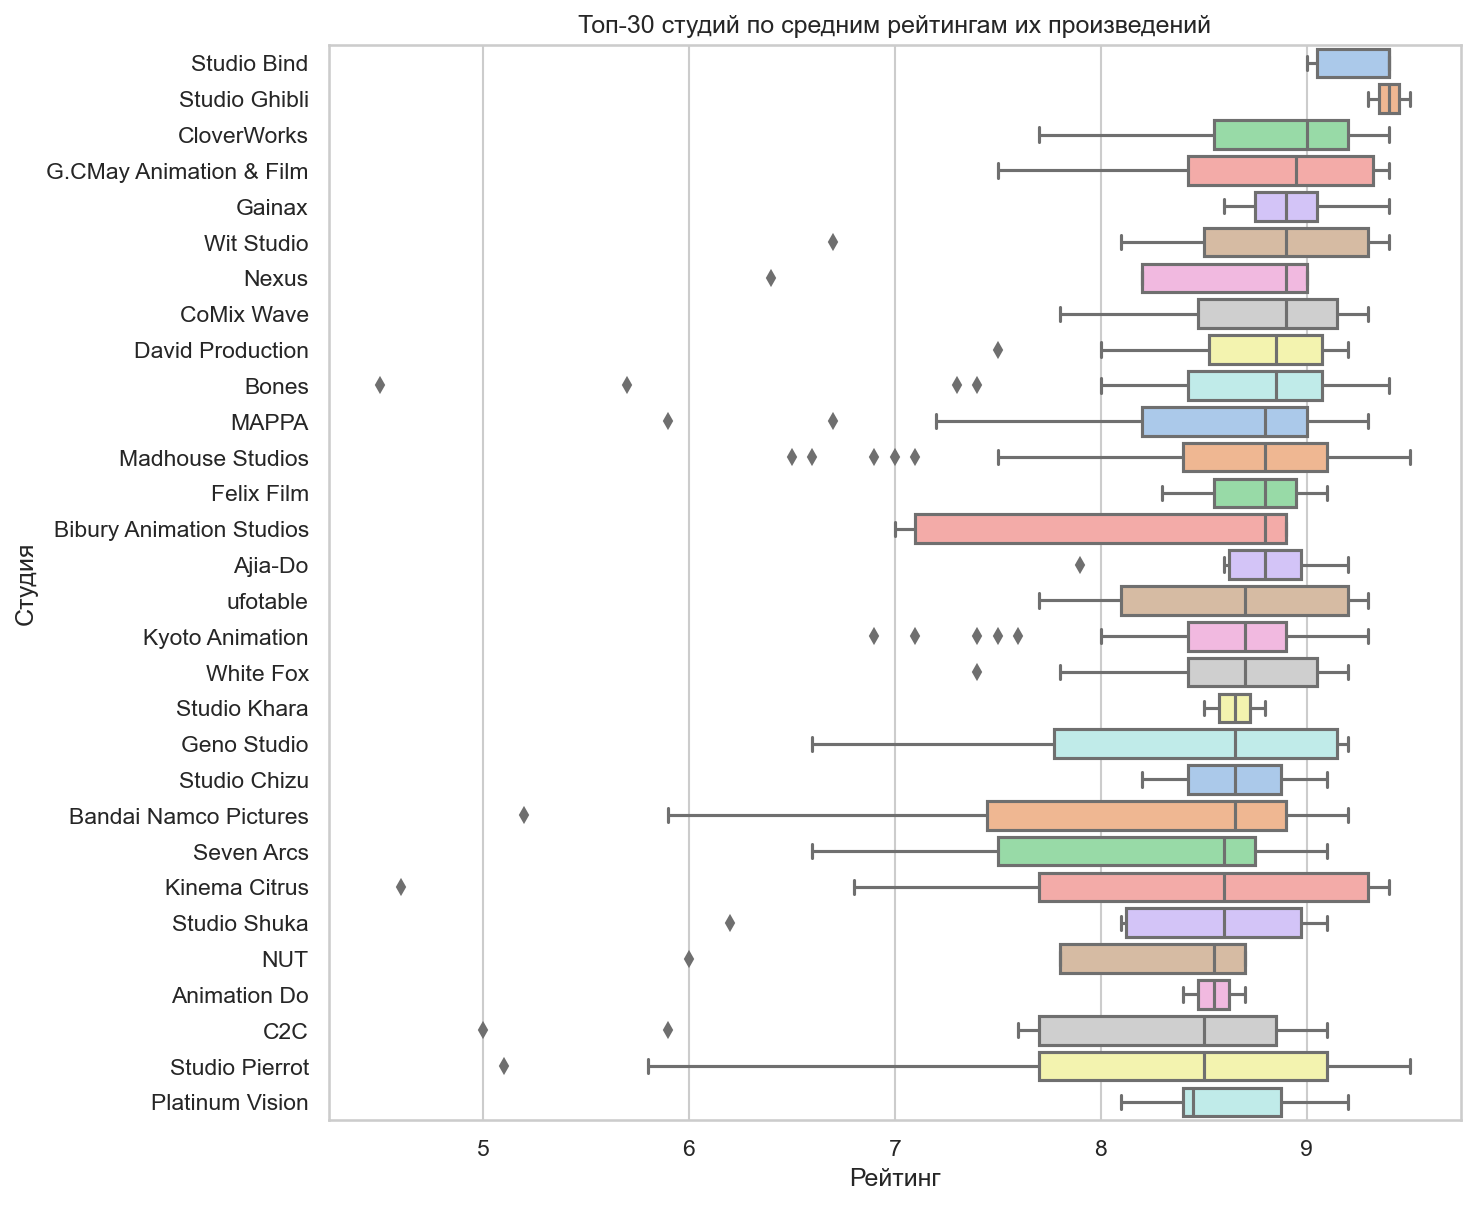

In [46]:
plt.figure(figsize=(10, 8), dpi=150)
sns.set(style="whitegrid")

sns.boxplot(x=studio_df[studio_mask]['rating'],
            y=studio_df[studio_mask]['studio'],
           order=groupes_studio_df,
           palette='pastel')
plt.tight_layout()
plt.ylabel('Студия')
plt.xlabel('Рейтинг')
plt.title('Топ-30 студий по средним рейтингам их произведений');

Итого мы имеем список надежных студий анимации, чьи произведения в среднем будут отличаться качеством.

### Анализ жанров
Для начала понадобится разбить колонку с жанрами.

In [26]:
genres_df = pd.DataFrame([])

def genres_separate(series):
    global genres_df
    genres_dict = {}
    genres_dict['genres'] = series['genres'].split(';')
    genres_dict['title'] = series['title']
    genres_dict['rating'] = series['rating']
    if genres_df.empty:
        genres_df = pd.DataFrame(genres_dict)
    else:
        genres_df = pd.concat([genres_df, pd.DataFrame(genres_dict)])
df[['title', 'genres', 'rating']].apply(genres_separate, axis=1)
genres_df = genres_df.dropna()
genres_df

,genres,title,rating
0,Гарем,Мои девушки 2,7.6
1,Комедия,Мои девушки 2,7.6
2,Романтика,Мои девушки 2,7.6
3,Сёнэн,Мои девушки 2,7.6
4,Школа,Мои девушки 2,7.6
...,...,...,...
3,Повседневность,Красавцы из клуба защитников Земли,6.0
4,Школа,Красавцы из клуба защитников Земли,6.0
0,Комедия,Работа!!,7.9
1,Повседневность,Работа!!,7.9


Убедимся в том, что все отработало без ошибок, оценив среднее.

In [27]:
genres_df[['title', 'rating']].drop_duplicates()['rating'].mean()

7.835286859962986

Оценки совпали, значит ошибок нет. Проверим гипотезу о равномерности распределения жанров с помощью **Критерия Хи-квадрат Пирсона**.

Гипотезы:

H0: *X₁, ..., Xₙ ~ iid U[a, b]*

H0: *X₁, ..., Xₙ ͊!~ iid U[a, b]*

In [28]:
genres_counts = genres_df['genres'].value_counts()
n = genres_df.shape[0]
n_genres = len(genres_counts)
expect = n / n_genres

chi2, p_value = stats.chisquare(genres_counts, f_exp=[expect] * n_genres)
print(f'p_value = {p_value.round(5)}')

p_value = 0.0


Имеем статистически значимый результат, значит **жанры не одинаково популярны**. Построим для них визуализацию.

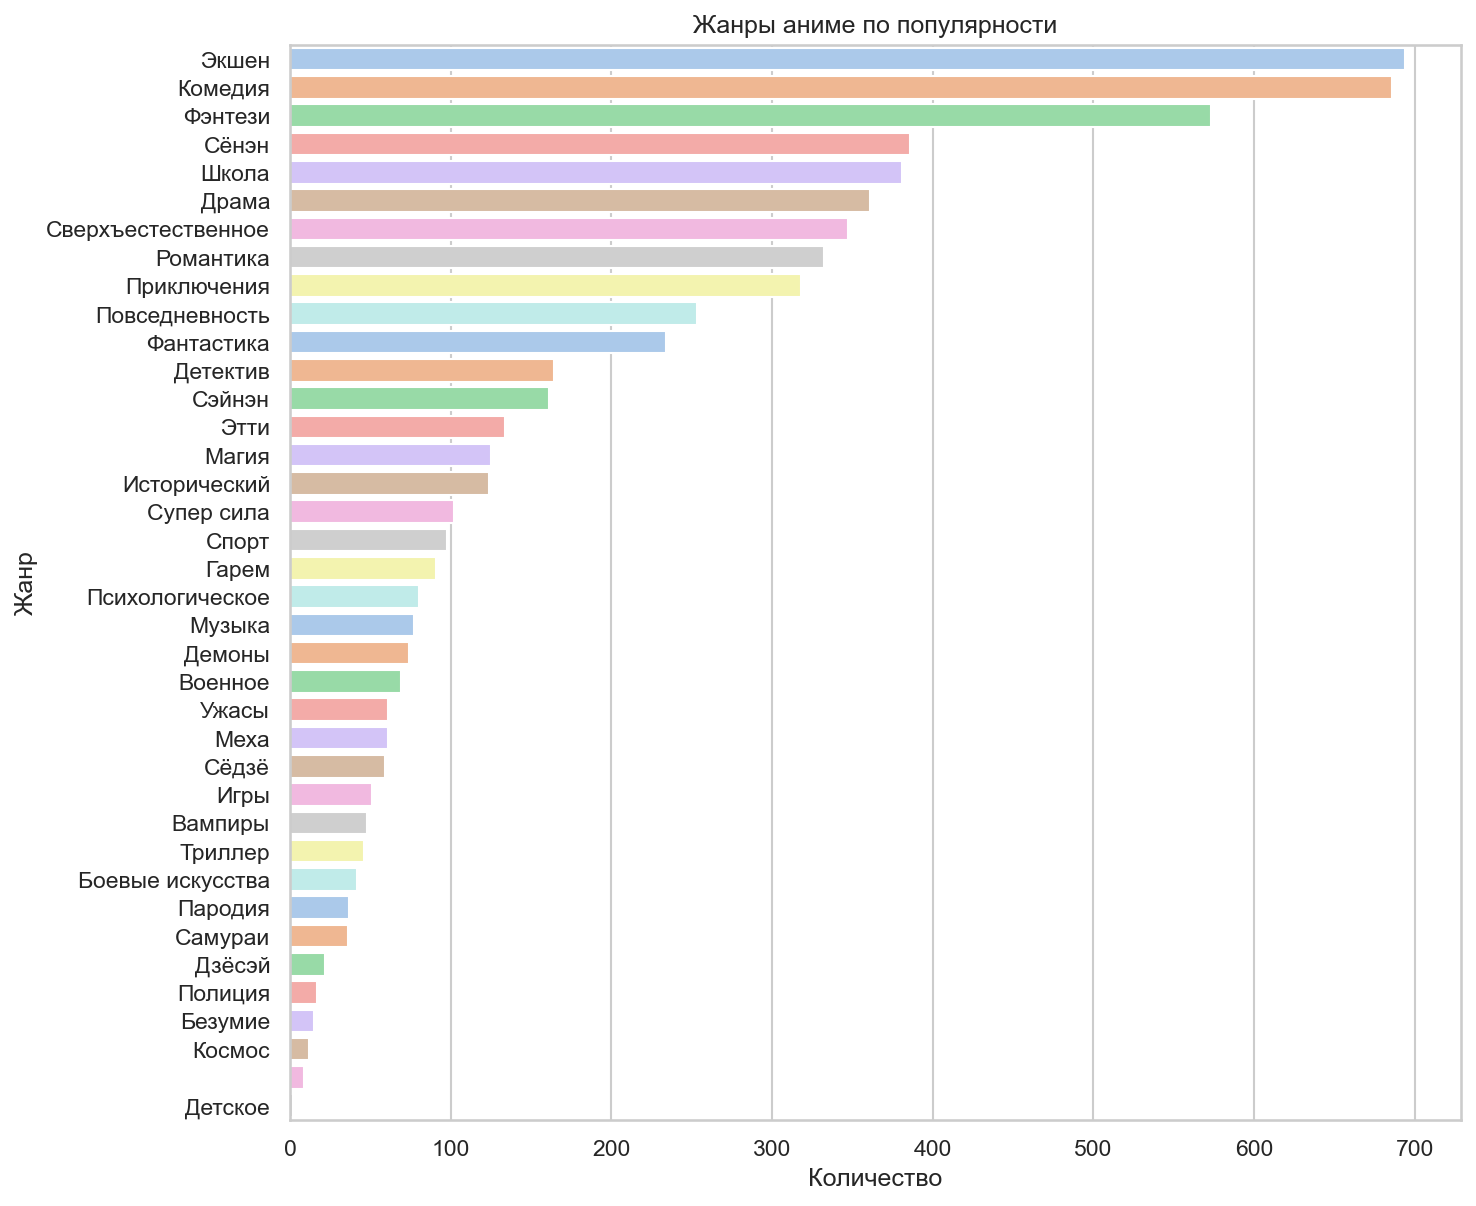

In [29]:
plt.figure(figsize=(10, 8), dpi=150)
sns.set(style="whitegrid")

sns.barplot(y=genres_counts.index, x=genres_counts, palette='pastel')
plt.tight_layout()
plt.ylabel('Жанр')
plt.xlabel('Количество')
plt.title('Жанры аниме по популярности');

Теперь сравним средние оценки каждого жанра. Гипотезы:

H0: μ₁ = ... = μₙ

H1: μ₁ ≠ ... ≠ μₙ (хотя бы 1)

In [30]:
model = ols('rating ~ C(genres)', data=df).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(genres),1430.894159,884.0,2.183622,6.303623e-29
Residual,592.276643,799.0,NaN,NaN


Как видим нулевая **гипотеза отвергается**, качество зависит от жанра. Построим распределение средних оценок по жанру. Также сохраним жанры, чья средняя оценка ниже средней оценки генеральной совокупности, будем избегать таких жанров при рекомендациях.

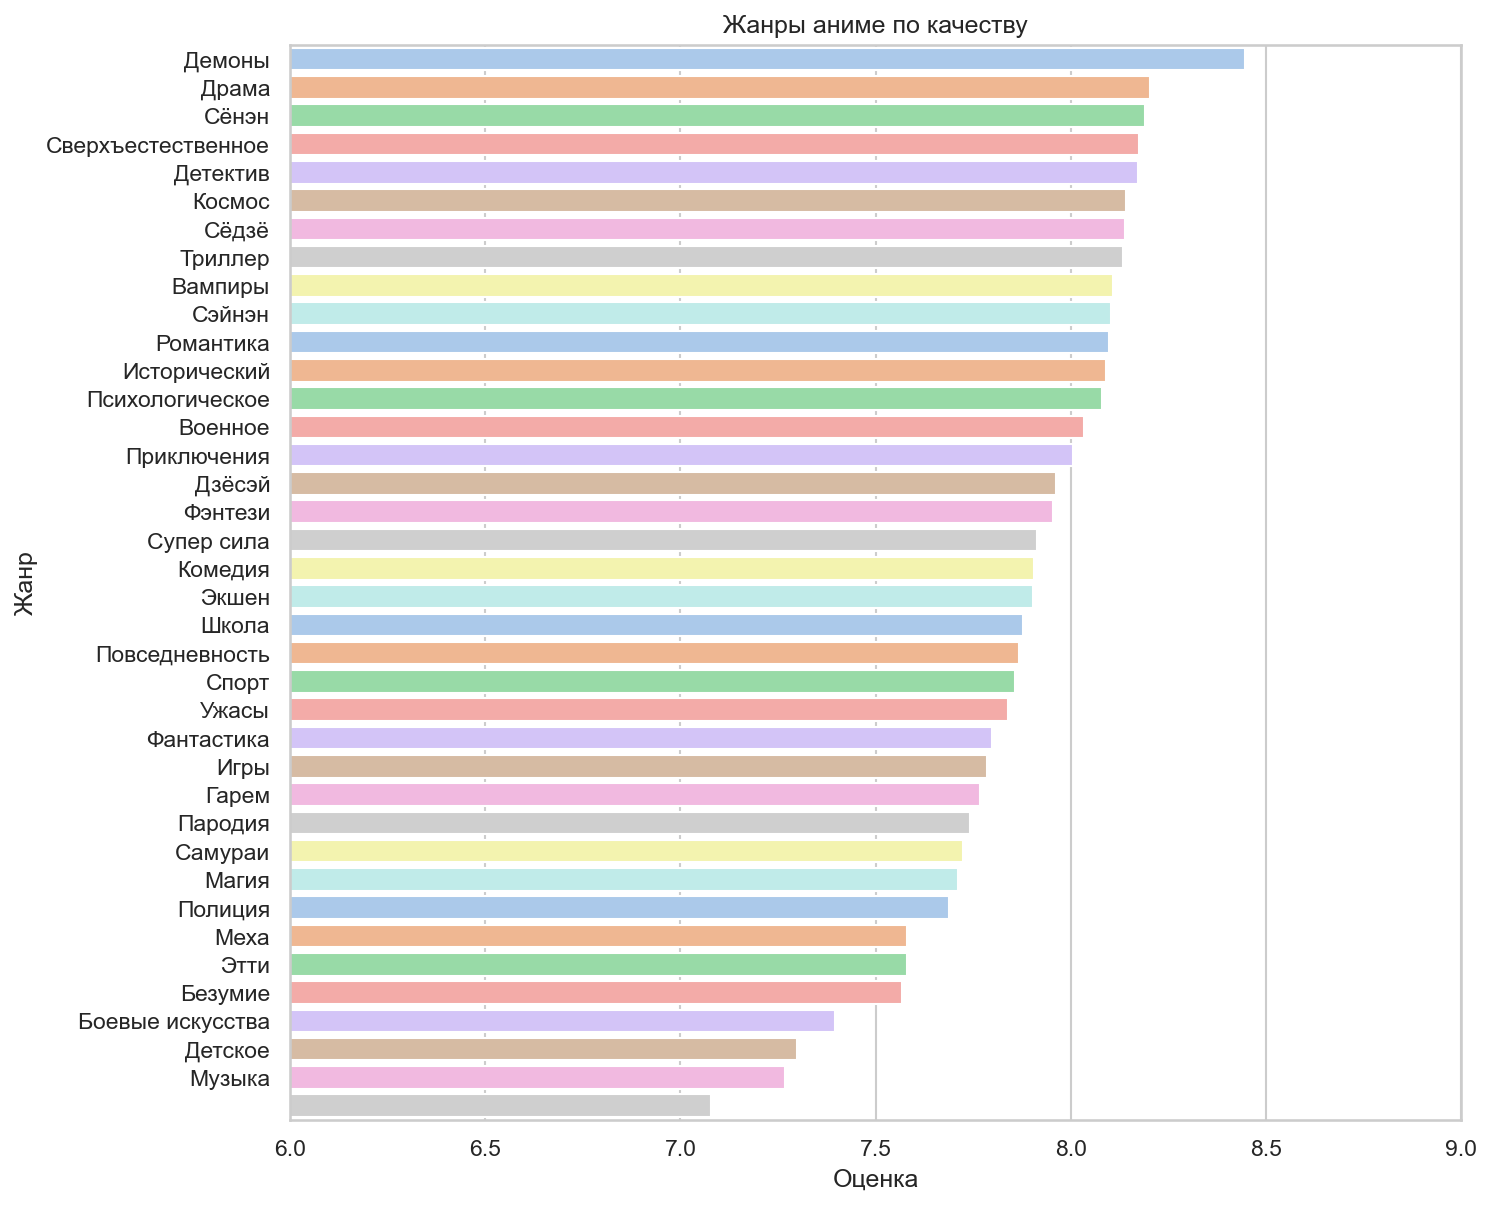

In [69]:
gr_genres = genres_df
gr_genres = gr_genres[['rating', 'genres']].groupby('genres').agg('mean').sort_values('rating', ascending=False)
bad_genres = gr_genres[gr_genres['rating'] < df['rating'].mean()].index.to_list()[:-1]

plt.figure(figsize=(10, 8), dpi=150)
sns.set(style="whitegrid")

sns.barplot(y=gr_genres.index, x=gr_genres.rating, palette='pastel')
plt.tight_layout()
plt.xlim([6, 9])
plt.ylabel('Жанр')
plt.xlabel('Оценка')
plt.title('Жанры аниме по качеству');

### Также проведем анализ зависимости рейтинга от типа произведения.

Сравним средние оценки каждого жанра. Гипотезы:

H0: μ₁ = ... = μₙ

H1: μ₁ ≠ ... ≠ μₙ (хотя бы 1)

In [32]:
model = ols('rating ~ C(type)', data=df).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(type),19.188084,4.0,4.019096,0.003007
Residual,2003.982718,1679.0,NaN,NaN


Мы **получили значимое** различие в каких-то группах. Проверим в каких именно при помощи **теста Тьюки**, учитывающего множественные сравнения.

In [33]:
tukey = st.multicomp.pairwise_tukeyhsd(endog=df['rating'], groups=df['type'], alpha=0.05)
print(tukey)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2  meandiff p-adj   lower  upper  reject
---------------------------------------------------------
      ONA       OVA  -0.0184 0.9999  -0.415 0.3783  False
      ONA     Спешл  -0.0414 0.9985 -0.4333 0.3504  False
      ONA ТВ Сериал   0.0748 0.9632 -0.2307 0.3802  False
      ONA     Фильм   0.3793 0.0418  0.0087 0.7499   True
      OVA     Спешл  -0.0231 0.9998 -0.3969 0.3507  False
      OVA ТВ Сериал   0.0931 0.8963 -0.1888 0.3751  False
      OVA     Фильм   0.3977 0.0174  0.0462 0.7491   True
    Спешл ТВ Сериал   0.1162 0.7778 -0.1589 0.3913  False
    Спешл     Фильм   0.4207 0.0081  0.0748 0.7667   True
ТВ Сериал     Фильм   0.3045  0.006  0.0607 0.5484   True
---------------------------------------------------------


Получается, что различие имеет место из-за фильмов, чьи оценки в среднем выше. Построим визуализацию.

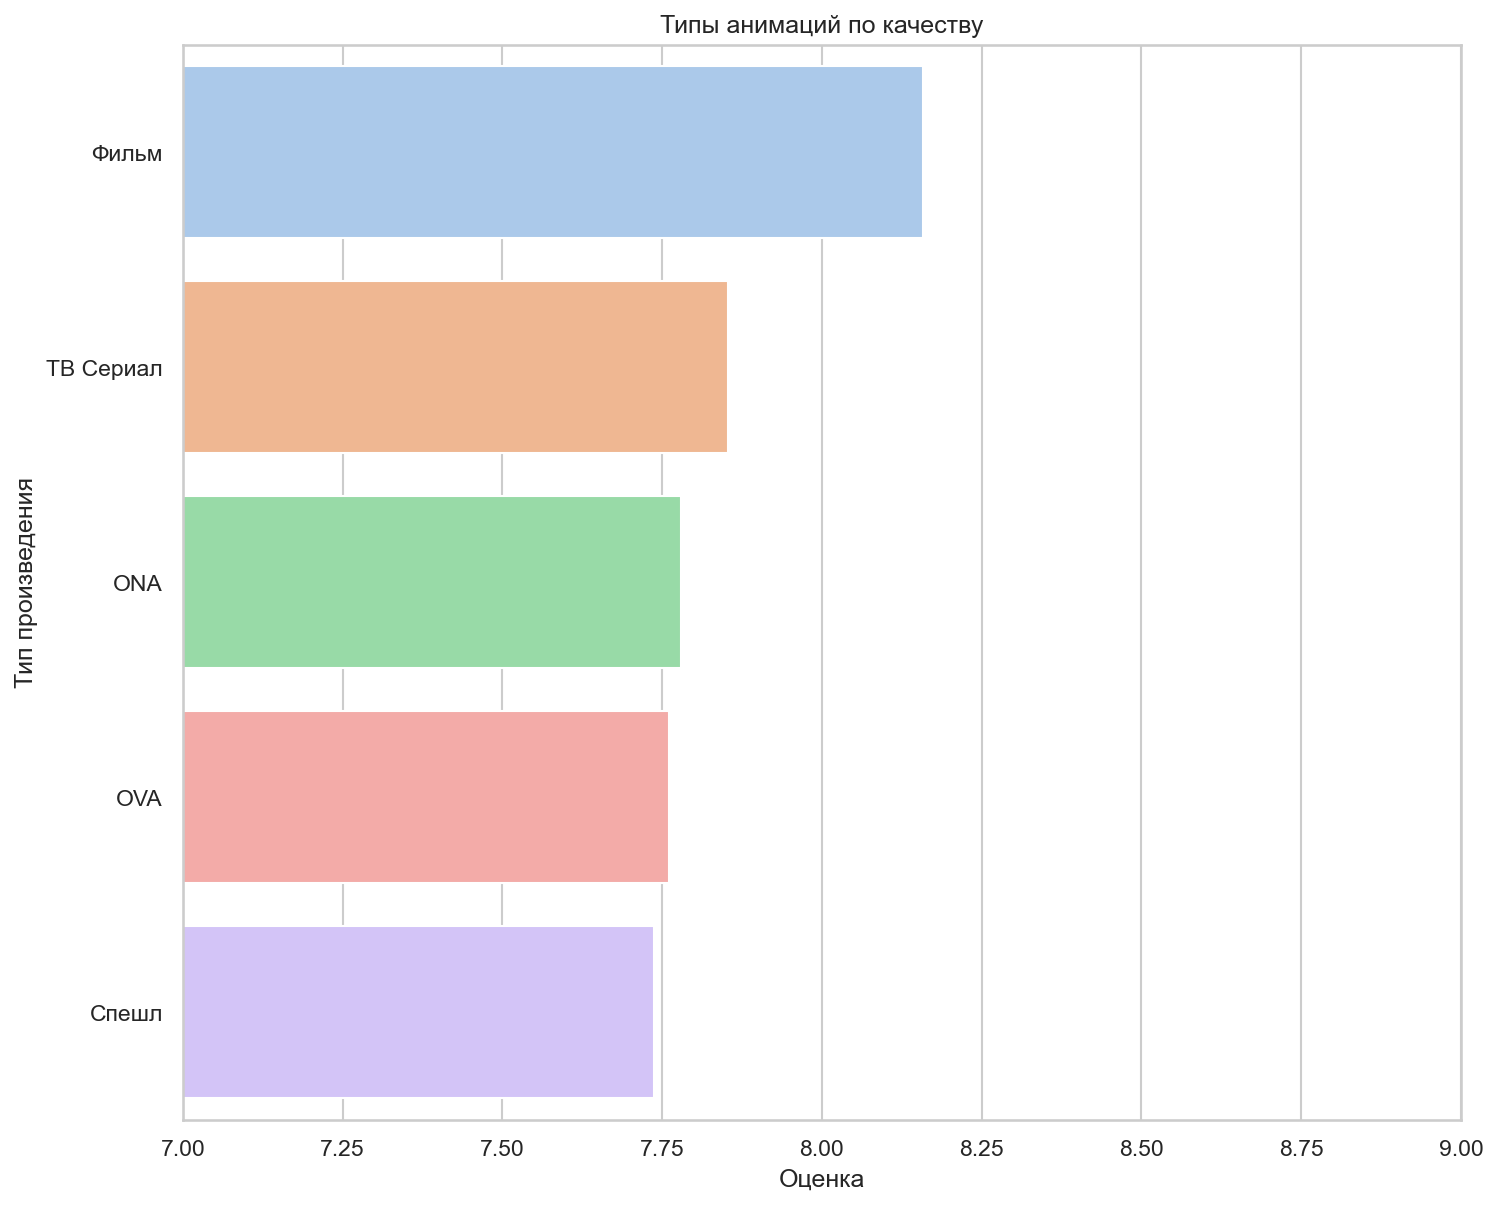

In [52]:
type_df = df[['type', 'rating']]
type_df = type_df[['rating', 'type']].groupby('type').agg('mean').sort_values('rating', ascending=False)

plt.figure(figsize=(10, 8), dpi=150)
sns.set(style="whitegrid")

sns.barplot(y=type_df.index, x=type_df.rating, palette='pastel')
plt.tight_layout()
plt.xlim([7, 9])
plt.ylabel('Тип произведения')
plt.xlabel('Оценка')
plt.title('Типы анимаций по качеству');

Итого имеем, что в среднем фильмы лучше всех остальных типов аниме.

## Ну и наконец попробуем найти лучших представителей, с которых стоит начать знакомство с культурой японской анимации.

In [35]:
df.head()

,title,genres,rating,rating_voters,season,studio,origin,pg,type,episode_count
0,Мои девушки 2,Гарем;Комедия;Романтика;Сёнэн;Школа,7.6,1688,Осень 2023,SynergySP,ТВ Сериал,16+,ТВ Сериал,12
1,Волейбольный клуб старшей школы Сэйин,Драма;Повседневность;Спорт;Школа,7.5,1458,Зима 2021,David Production,ТВ Сериал,12+,ТВ Сериал,12
2,Компания «Маги-Люмьер»,Комедия;Сёнэн;Фэнтези;Экшен,7.5,133,Осень 2024,J.C. Staff,ТВ Сериал,16+,ТВ Сериал,1
3,Звучи! Эуфониум 2: Спешлы,Комедия;Музыка;Школа,7.2,137,None,None,Спешл,16+,Спешл,7
4,Граница пустоты 5: Спираль парадокса,Детектив;Драма;Романтика;Сверхъестественное;Тр...,8.8,603,None,ufotable,Фильм,18+,Фильм,1


Отсортируем общий датафрейм, на основе анализа выше отфильтруем каждую из категорий и наконец найдем лучшие аниме для старта.

In [78]:
pattern = '|'.join(map(re.escape, bad_genres))

filtered_df = df[~df['genres'].str.contains(pattern, case=False, na=False)] # Исключим аниме со спорными жанрами

# Отсортируем по оценкам и количеству голосов, а затем проверим, является ли студия проверенной и является ли произведение фильмом
filtered_df.drop_duplicates(subset=['title']).sort_values(['rating', 'rating_voters'], ascending=False)[(df.studio.isin(top_studios.to_list())) & (df.type == 'Фильм')].head(10)

,title,genres,rating,rating_voters,season,studio,origin,pg,type,episode_count
93,Унесённые призраками,Драма;Приключения;Сверхъестественное,9.5,7280,None,Studio Ghibli,Фильм,16+,Фильм,1
513,Этот глупый свин не понимает мечту девочки-зай...,Драма;Комедия;Романтика;Сверхъестественное;Школа,9.4,25680,None,CloverWorks,Фильм,16+,Фильм,1
1559,Истребитель демонов: Поезд «Бесконечный»,Демоны;Исторический;Сверхъестественное;Сёнэн;Э...,9.3,31346,None,ufotable,Фильм,18+,Фильм,1
982,Твоё имя,Драма;Романтика;Сверхъестественное;Школа,9.3,26683,None,CoMix Wave,Фильм,16+,Фильм,1
597,Форма голоса,Драма;Сёнэн;Школа,9.3,24062,None,Kyoto Animation,Фильм,16+,Фильм,1
1200,Магическая битва 0. Фильм,Фэнтези;Экшен,9.3,22619,None,MAPPA,Фильм,18+,Фильм,1
1129,Мой сосед Тоторо,Комедия;Приключения;Сверхъестественное,9.3,3047,None,Studio Ghibli,Фильм,16+,Фильм,1
548,Вайолет Эвергарден: Вечность и призрак пера,Драма;Повседневность;Фэнтези,9.2,5533,None,Kyoto Animation,Фильм,12+,Фильм,1
357,Дитя погоды,Драма;Повседневность;Романтика;Фэнтези,9.1,13068,None,CoMix Wave,Фильм,16+,Фильм,1
1176,Ученик чудовища,Приключения;Сверхъестественное,9.1,5210,None,Studio Chizu,Фильм,16+,Фильм,1


В десятку самых подходящих попало всего 6 аниме, которые являются самостоятельными произведениями. Поэтому, если вы только начинаете, то с уверенностью могу вам посоветовать посмотреть следующие произведения:
- [Унесённые призраками](https://animego.org/anime/unesennye-prizrakami1-268)
- [Твоё имя](https://animego.org/anime/tvoe-imya-107)
- [Форма голоса](https://animego.org/anime/forma-golosa-267)
- [Мой сосед Тоторо](https://animego.org/anime/moy-sosed-totoro1-307)
- [Дитя погоды](https://animego.org/anime/tenki-no-ko-1082)
- [Ученик чудовища](https://animego.org/anime/uchenik-chudovischa-754)

Эти аниме должны понравиться абсолютному большинству людей.

Спасибо за внимание